# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
#!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import random
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import sklearn_crfsuite as CRF

from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

     |████████████████████████████████| 743 kB 5.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

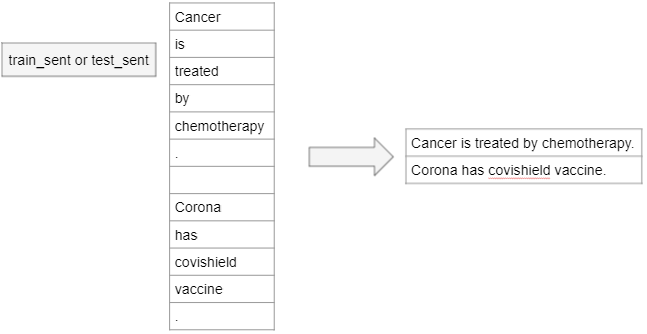

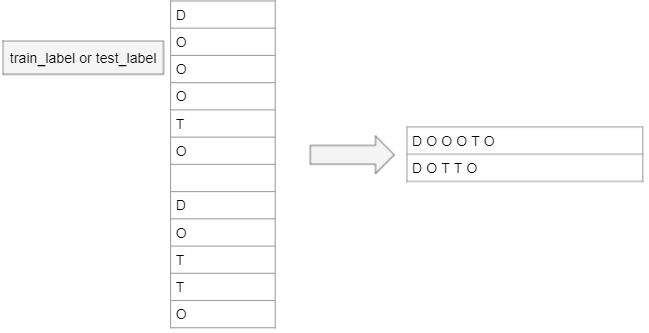

In [3]:
with open('/content/drive/MyDrive/NLP Assignment/dataset/train_sent', 'r') as train_sent_file:
  train_words_raw = train_sent_file.readlines()

with open('/content/drive/MyDrive/NLP Assignment/dataset/train_label', 'r') as train_labels_file:
  train_labels_raw = train_labels_file.readlines()

with open('/content/drive/MyDrive/NLP Assignment/dataset/test_sent', 'r') as test_sent_file:
  test_words_raw = test_sent_file.readlines()

with open('/content/drive/MyDrive/NLP Assignment/dataset/test_label', 'r') as test_labels_file:
  test_labels_raw = test_labels_file.readlines()

In [4]:
# Print the 6th sentence in the test set i.e. index value 5.
print(train_words_raw[5])

# Print the labels of this sentence
print(train_labels_raw[5])

=

O



In [5]:
import re
# We join all invididual words into a single string after removing the newline characters using strip method
# Then we split on double spaces which denotes the removed empty new line which is our sentence separator
def process_word_list(raw_multiline_words):
    joined_list = " ".join(line.strip() for line in raw_multiline_words)
    return joined_list.split('  ')  

In [6]:
## Save as csv
def save_list_to_csv(sent_list,name):
    save_dict ={"col1":sent_list}
    pd.DataFrame.from_dict(save_dict).to_csv(name)

In [7]:
train_sentences = process_word_list(train_words_raw)
test_sentences = process_word_list(test_words_raw)
train_labels = process_word_list(train_labels_raw)
test_labels = process_word_list(test_labels_raw)

In [8]:
save_list_to_csv(test_sentences,"test.csv")

In [9]:
save_list_to_csv(test_labels,"test_labels.csv")

In [10]:
#Print a list of random sentences from Train Data Set
for i in range(5):
    sampler  = random.randint(0,len(train_sentences)-1)
    print("Sentence ", i+1, ":", train_sentences[sampler])
    print("Label    ", i+1, ":", train_labels[sampler],"\n") 

Sentence  1 : Meta-analysis of typhoid vaccine efficacy trials showed that whole cell vaccines are more effective than either the oral , attenuated vaccine or the Vi polysaccharide vaccine
Label     1 : O O D T O O O O O O O O O O O O O O O O O O O O O O 

Sentence  2 : Neonatal BAEP specificity for excluding subsequent hearing loss was 76 %
Label     2 : O O O O O O D D O O O 

Sentence  3 : methods : the author reviews the use of several endobronchial treatment modalities that can augment standard antitumor therapies for advanced lung cancer , including rigid and flexible bronchoscopy , laser therapy , endobronchial prosthesis , and photodynamic therapy
Label     3 : O O O O O O O O O T T T T T T T T T O O D D O O O O O O O O O O O O O O O O 

Sentence  4 : Linear regression analysis showed that the lower the qCT at the beginning of the observation period , the higher was the percentage increase of spinal qCT in the entire group during 12 mo of dancing ( r = 0.52 , P & # 60 ; 0.0001 

In [11]:
#Print a list of random sentences from Test Data Set
for i in range(5):
    sampler  = random.randint(0,len(test_sentences)-1)
    print("Sentence ", i+1, ":", test_sentences[sampler])
    print("Label    ", i+1, ":", test_labels[sampler],"\n") 

Sentence  1 : The effect was most pronounced in the central part of the treated area , where no positive fox was found in the 2 months before the end of the trial
Label     1 : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Sentence  2 : Sodium in heart failure
Label     2 : O O D D 

Sentence  3 : Administration of dexamethasone induces proteinuria of glomerular origin in mice
Label     3 : O O T O D O O O O O 

Sentence  4 : We conclude that antimicrobial/ antituberculous agents have only a minor short-term effect in long-lasting CGM of undetermined cause
Label     4 : O O O T T T O O O O O O O O D O O O 

Sentence  5 : Thoracoscopy for empyema in children
Label     5 : T O D O O 



### Count the number of sentences in the processed train and test dataset 

In [12]:
print("Train Dataset Length:  {}\nTrain Label Length : {}\n".format(len(train_sentences), len(train_labels)))

Train Dataset Length:  2599
Train Label Length : 2599



### Count the number of lines of labels in the processed train and test dataset.

In [13]:
print("Test Dataset Length:  {}\nTest Label Length : {}\n".format(len(test_sentences), len(test_labels)))

Test Dataset Length:  1056
Test Label Length : 1056



## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



In [14]:
### For data exploration we will merge the train and test datasets
explore_sentences= []
explore_labels = []
explore_sentences.extend(train_sentences)
explore_sentences.extend(test_sentences)
explore_labels.extend(train_labels)
explore_labels.extend(test_labels)

In [15]:
print ("Total Dataset is of Length {}\n".format(len(explore_sentences)))

Total Dataset is of Length 3655



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [16]:
#We will disable the parser, ner as we do not require it for Concept identification
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7ff1ceb83e10>)]

In [17]:
lemma = []
text = []
pos = []
dep = []
shape =[]


for sent in tqdm(explore_sentences):
    doc = nlp(sent)
    for tok in doc: 
        text.append(tok.text.lower())
        lemma.append(tok.lemma_.lower())
        pos.append(tok.pos_.lower())
        dep.append(tok.dep_.lower())
        shape.append(tok.shape_.lower())

100%|██████████| 3655/3655 [00:13<00:00, 264.92it/s]


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [18]:
#Analyse the Data before we do concept analysis
token_df = pd.DataFrame({'text':text,'lemma':lemma,'pos':pos, 'dep':dep, 'shape':shape})
token_df.head()

,text,lemma,pos,dep,shape
0,all,all,det,,xxx
1,live,live,adj,,xxxx
2,births,birth,noun,,xxxx
3,>,>,x,,>
4,or,or,cconj,,xx


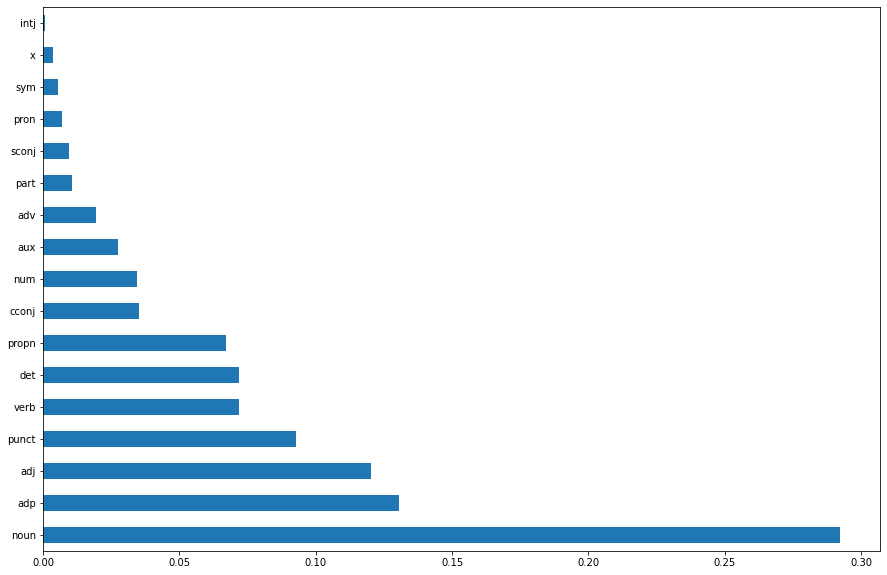

In [19]:
plt.figure(figsize=(15,10))
token_df.pos.value_counts(normalize=True).plot.barh()

**Observation** 
-  Around 30% or the words are Nouns, followed Adverbs and Adjective. Lets now filter the dataset by nouns and pronouns and do some EDA

In [20]:
#filter by only Nouns and Proper Nouns

token_df_f= token_df.loc[token_df.pos.isin(['noun','propn'])]

In [21]:
token_df_f.groupby(by=['pos'], sort=True)

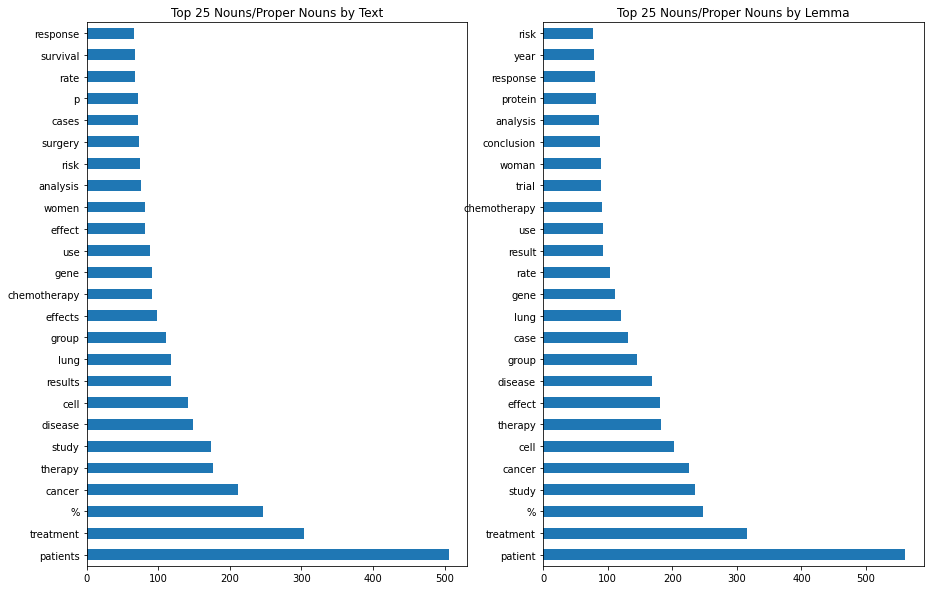

In [22]:
plt.figure(figsize=(15, 10))
fig = plt.subplot(1,2,1)
plt.title("Top 25 Nouns/Proper Nouns by Text")
token_df_f.text.value_counts().head(25).plot(kind='barh' )
plt.subplot(1,2,2)
plt.title("Top 25 Nouns/Proper Nouns by Lemma")
token_df_f.lemma.value_counts().head(25).plot(kind='barh')
plt.show()

**Observation** - In the top 25 words there is some difference if we use Lemmas vs the original words. 
- In general Lemmas look to be more meaninful 
- However can nouns be used as disease or treatment names, is not clear. Lets analyse further

In [23]:
token_df_f.lemma.value_counts().tail(25)

encode                  1
cefuroxime              1
rainbow                 1
distortion              1
band                    1
laevorotatory           1
biguanide               1
glycosylphosphatidyl    1
haemoptysis             1
responder               1
disposition             1
ohio                    1
afferent                1
internus                1
past                    1
neurotrauma             1
bending                 1
haemophila              1
disablement             1
trivalent               1
average                 1
ivads                   1
lesbian                 1
stz                     1
spray                   1
Name: lemma, dtype: int64

**Observation** : 
- The the lower frequency nouns do look like disease names. So they can be used in the CRF to isolate the features

## Defining features for CRF





In [24]:
# Let's define the features to get the feature value for one word.
#Explore Disease Names and Treatment Names for computing Features
def print_samples(data,labels, no_of_samples):
    sample_seq = random.sample(range(len(data)-1),no_of_samples)
    disease_list=[]
    treatment_list=[]
    for sample_no in sample_seq:
        sentence=data[sample_no]
        label=labels[sample_no]
        for word, label in zip(sentence.split(),label.split()):
            if (label=='D'):
              disease_list.append(word)
            if (label=='T'):
              treatment_list.append(word)
    print("*"*10+"DISEASE LIST"+"*"*10)
    print(disease_list)
    print("*"*10+"TREATMENT LIST"+"*"*10)
    print(treatment_list)


In [25]:
print_samples(train_sentences, train_labels,100)

**********DISEASE LIST**********
['early-stage', 'nsclc', 'micrometastatic', 'disease', 'small', 'cell', 'lung', 'cancer', '(', 'sclc', ')', 'vesicoureteric', 'reflux', 'chronic', 'aspecific', 'pancreatitis', 'psoriasis', 'digital', 'ring', 'block', 'wilson', "'s", 'disease', 'several', 'disorders', 'including', 'rheumatoid', 'arthritis', ',', 'primary', 'biliary', 'cirrhosis', ',', 'scleroderma', ',', 'fibrotic', 'lung', 'diseases', 'and', 'progressive', 'systemic', 'sclerosis', 'tracheobronchial', 'stenoses', 'Bradycardia', 'peripheral', 'colorectal', 'pulmonary', 'metastases', 'acute', 'myocardial', 'infarction', 'hepatitis', 'A', 'and', 'B', 'influenza', 'multiple', 'sclerosis', 'lung', 'cancer', 'tubal', 'pregnancy', 'anal', 'cancer', 'normal-tension', 'glaucoma', 'hormonal', 'dysfunction', 'testicular', 'cancer', 'endometriosis', 'HIV', 'infection', 'gunshot', 'wounds', 'hepatitis', 'A', 'and', 'B', 'Schistosoma', 'mansoni', 'infection', 'stage', 'i', 'or', 'ii', 'non-small', 'ce

**Observation** : 
- Its clear that last 3 letters *ism, ion,tor* etc and last 4 letters *ilia,elin,oxol* etc are good indicators of distinguishing words. 
- They can be used as features

In [26]:
#Function takes a sentence and returns a list of tags from SPACY, based on the tag_type argument

def getNLPTag(sent, tag_type='POS'):
    tagged_feature = {}
    doc = nlp(sent)
    for i,tok in enumerate(doc):
        if (tag_type=="POS"):
            tagged_feature[i]=tok.pos_.lower()
        elif (tag_type=="LEMMA"):
            tagged_feature[i]=tok.lemma_.lower()
        elif (tag_type=="SHAPE"):
            tagged_feature[i]=tok.shape_.lower()
        else:
            tagged_feature[i]=tok.text.lower()
    
    return tagged_feature

In [27]:
print(train_labels[45])
matches = re.finditer('[D]',train_labels[45])
for match in matches:
    print(match.start(), match.end())

O D D O O O O O O O O O O O O O O
2 3
4 5


In [28]:
#This method looks for the given pattern in the sentence  and uses the corresponding label set passed in
# to check for the presence of "D" or "T" in the labels for a matched sentence
# For labels having "D" and/or "T" it finds the disease and treatment and forms a concatented list 
# of them per sentence.
# @verbose keyword controls the logging from this method.
# The method finally returns a dataframe of a disease  and the treatments as the value.
# A dataframe of Disease and Pos tags
# A dataframe of Treatment and Pos tags

class color:
    BOLD = '\033[1m'
    END = '\033[0m'
    
def findSampleSentenceWithPattern(pattern, sentence_set, label_set, verbose=True):
    disease_treatment = {}
    disease_pos_set = set()
    treatment_pos_set = set()
    for sent_index, sentence in enumerate(sentence_set):
        #print("--", sentence)
        result = re.findall(pattern, sentence, re.IGNORECASE)
        if (result):         
            has_D_T = re.findall('[D|T]', label_set[sent_index])
            if has_D_T:
                if verbose: 
                    print(color.BOLD + "Sentence     : " + color.END, sentence) 
                    print(color.BOLD + "Label        : " + color.END, label_set[sent_index])
                doc = nlp(sentence)
                words = sentence.split(" ")
                disease_key = " ".join([words[int(match.start()/2)] for match in re.finditer('[D]', label_set[sent_index])])
                disease_pos_tag = " ".join([doc[int(match.start()/2)].pos_ for match in re.finditer('[D]', label_set[sent_index])])
                [disease_pos_set.add((words[int(match.start()/2)],doc[int(match.start()/2)].pos_)) for match in re.finditer('[D]', label_set[sent_index])]
                
                if  verbose:                    
                    print(color.BOLD + "Disease      : " + color.END, "-Not Available-" if not disease_key else disease_key)
                    print(color.BOLD + "Disease Tag  : " + color.END, "-Not Available-" if not disease_pos_tag else disease_pos_tag)
                
                treatment_key = " ".join([words[int(match.start()/2)] for match in re.finditer('[T]', label_set[sent_index])])
                treatment_pos_tag = " ".join([doc[int(match.start()/2)].pos_ for match in re.finditer('[T]', label_set[sent_index])])
                [treatment_pos_set.add((words[int(match.start()/2)],doc[int(match.start()/2)].pos_)) for match in re.finditer('[T]', label_set[sent_index])]
                
                if verbose:
                    print(color.BOLD + "Treatment    : " + color.END, "-Not Available-" if not treatment_key else treatment_key)
                    print(color.BOLD + "Treatment Tag: " + color.END, "-Not Available-" if not treatment_pos_tag else treatment_pos_tag)
                
                if disease_key:
                    for disease in disease_key.split():
                        if (disease not in  disease_treatment.keys()):
                            disease_treatment[disease] = [treatment_key] if treatment_key else [];
                        else:                            
                            if treatment_key: disease_treatment[disease].append(treatment_key)
                if verbose: print("\n")
    
    if verbose:
        print(color.BOLD + "Disease -> Treatment Mapping" + color.END)
        for key in  disease_treatment:           
            print(key, disease_treatment[key])   
            
    disease_treatment_df = pd.DataFrame(disease_treatment.items(), columns=['disease','treatment'])
    
    if verbose:
        print(color.BOLD + "Disease Pos Tag " + color.END + "\n", disease_pos_set) 
        
    disease_pos_df = pd.DataFrame(disease_pos_set, columns =['disease', 'pos'])
       
    if verbose:
        print(color.BOLD + "Treatment Pos Tag " + color.END + "\n", treatment_pos_set) 
        
    treatment_pos_df = pd.DataFrame(treatment_pos_set, columns =['treatment', 'pos'])
        
    return disease_treatment_df, disease_pos_df, treatment_pos_df   

In [29]:
## Find Sample Sentences with Retinoblastoma
_,_,_ = findSampleSentenceWithPattern('.*retinoblastoma.*', train_sentences, train_labels)

Sentence     :  SETTING/PARTICIPANTS : A total of 1604 patients with retinoblastoma who survived at least 1 year after diagnosis , identified from hospital records in Massachusetts and New York during 1914 to 1984
Label        :  O O O O O O O O D O O O O O O O O O O O O O O O O O O O O O O
Disease      :  retinoblastoma
Disease Tag  :  NOUN
Treatment    :  -Not Available-
Treatment Tag:  -Not Available-


Sentence     :  RESULTS : Incidence of subsequent cancers was statistically significantly elevated only in the 961 patients with hereditary retinoblastoma , in whom 190 cancers were diagnosed , vs 6.3 expected in the general population ( relative risk ( RR ) , 30 ( 95 % confidence interval , 26-47 ) )
Label        :  O O O O O D O O O O O O O O O O O D O O O O D O O O O O O O O O O O O O O O O O O O O O O O O O O O
Disease      :  cancers retinoblastoma cancers
Disease Tag  :  NOUN NOUN NOUN
Treatment    :  -Not Available-
Treatment Tag:  -Not Available-


Sentence     :  Cumulative 

**Observation** - 
- Retinoblastoma is in the training dataset. 
- The Type is a **Noun**. 
- Also in few cases its preceded by an ajective. 
- In some cases the treatment is not available

In [30]:
disease_treatment_df, disease_pos_df, treatment_pos_df = \
    findSampleSentenceWithPattern('.*', train_sentences, train_labels, False)

In [31]:
disease_pos_df[~disease_pos_df.disease.str.isalpha()]

,disease,pos
8,non-small,PUNCT
9,Virchow-Robin,PROPN
87,Surgical-site,ADJ
97,non-recurrent,ADJ
100,short-bowel,ADV
...,...,...
1627,non-small,ADJ
1632,),NOUN
1633,extensive-disease,ADJ
1642,Extra-gastrointestinal,ADJ


In [32]:
treatment_pos_df[~treatment_pos_df.treatment.str.isalpha()]

,treatment,pos
2,CJ-11,PROPN
5,covered-ems,VERB
7,BAM-M,PROPN
19,fenfluramine-phentermine,NOUN
28,platinum-based,NOUN
...,...,...
1512,fenfluramine-phentermine,DET
1527,omega3,NOUN
1533,D3,PUNCT
1541,Q-switched,ADP


**Observation** 
 - Both disease and treatment have non alphabetic characters. This can be harvested as features

In [33]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, feature_dict):
  word = sentence[pos]
  pos_tag=feature_dict['POS']
  lemma_tag = feature_dict['LEMMA']
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[:4]=' + word[:4],     # first four characters
    'word[:3]=' + word[:3],     # first three characters
    'word[:2]=' + word[:2],     # first two characters  
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-4:]=' + word[-4:],     # last four characters
    'word[-2:]=' + word[-2:],   # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.isNotAlpha=%s' %(not word.isalpha()), #word is having non alphabet characters
    'word.postag=%s'% pos_tag[pos], #post tag of the word
    'word.lemmatag=%s'% lemma_tag[pos], #post tag of the word
    'word.isNoun=%s'% ((pos_tag[pos]).lower()=="noun"), #word is noun
    'words.postag.isProNoun=%s' % ((pos_tag[pos]).lower()=="propn")  #is the word PropNoun
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),
    'prevword.postag=%s'% pos_tag[pos-1],
    'prevword.isNoun=%s'% ((pos_tag[pos-1]).lower()=="noun"), #pos tag of the word is noun
    'prevword.isAdj=%s'% ((pos_tag[pos-1]).lower()=="adj") , # pos tag is adjective
    'prevword.isNoun=%s'% ((pos_tag[pos-1]).lower()=="propn"), ##is the word PropNoun
    'prevword[-3:]=' + prev_word[-3:],     # last three characters
    'prevword[-2:]=' + prev_word[-2:],   # last two characters
    'prev_word[:3]=' + prev_word[:3],     # first three characters
    'prev_word[:2]=' + prev_word[:2],     # first two characters 
    'prev_words.lemma=%s' % (lemma_tag[pos-1]), # Lemma of the word 
        
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [34]:
# Write a code to get features for a sentence.

def getFeaturesForOneSentence(sentence):
  feature_dict ={}
  feature_dict['POS'] =  getNLPTag(sentence, "POS")
  feature_dict['LEMMA'] =  getNLPTag(sentence, "LEMMA")
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos, feature_dict) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [35]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [36]:
example_sentence = train_sentences[30]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The survey indicated a variety of thermal care styles


['word.lower=indicated',
 'word[:4]=indi',
 'word[:3]=ind',
 'word[:2]=in',
 'word[-3:]=ted',
 'word[-4:]=ated',
 'word[-2:]=ed',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'word.isNotAlpha=False',
 'word.postag=verb',
 'word.lemmatag=indicate',
 'word.isNoun=False',
 'words.postag.isProNoun=False',
 'prev_word.lower=survey',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False',
 'prevword.postag=noun',
 'prevword.isNoun=True',
 'prevword.isAdj=False',
 'prevword.isNoun=False',
 'prevword[-3:]=vey',
 'prevword[-2:]=ey',
 'prev_word[:3]=sur',
 'prev_word[:2]=su',
 'prev_words.lemma=survey']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [37]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

### Define the labels as the target variable for test and the train dataset

In [38]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [39]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [40]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [41]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9194978869281576

### Manual Optimization 

In [42]:
#Trying to optimize few parameters

#Creating the CRF model
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)
crf.fit(X_train, Y_train)

# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)

In [43]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9215516037841686

**Observation** : 
- The accuracy increase to 92% after tuning. This could be a good model

### Checking if increasing iterations causes improvement

In [44]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=1000,
          all_possible_transitions=False)
crf.fit(X_train, Y_train)

# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9220459695472617

**Observation** : 
- There is a small improvement by increasing the number of runs. This is our best model

In [45]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 10
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

for i in range(5):
    id  = random.randint(0,len(test_sentences)-1)
    print("Sentence:",test_sentences[id])
    print("Orig Labels:", Y_test[id])
    print("Pred Labels:", Y_pred[id])

Sentence: The most common indication leading to diagnosis was abnormal ultrasound finding ( 48.2 % ) , followed by advanced maternal age ( 44.4 % )
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: The average age at onset was 27 years
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: Because the symptoms of rhinovirus colds are attributed to the inflammatory response to infection , we studied the effects of treatment with clarithromycin on the symptomatic and inflammatory response to nasal inoculation with rhinovirus
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

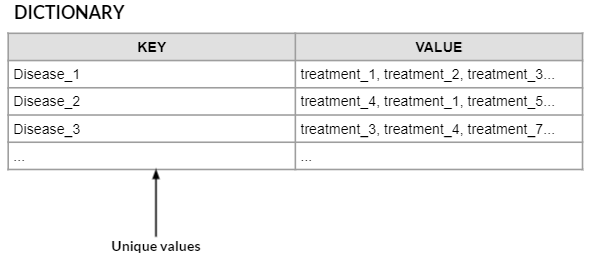

In [46]:
#Convert each test sentence prediction into space separated string and add to list
y_pred_labels = []
for pred in Y_pred:
    y_pred_labels.append(" ".join([tok for tok in pred]))

In [47]:
#Create a dictionay of all test sentences and their predicted disease/treatment 
disease_treatment_df,_,_ = findSampleSentenceWithPattern('.*', test_sentences, y_pred_labels, False)
disease_treatment_df

,disease,treatment
0,dehydration,[]
1,macrosomic,[good glycemic control]
2,infants,[good glycemic control]
3,in,"[good glycemic control, G-CSF treatment, chemo..."
4,gestational,[good glycemic control]
...,...,...
576,stable,[aerosolized salbutamol]
577,glaucoma,[Brimonidine]
578,epithelial,[High-dose chemotherapy]
579,responsive,[`` Tandem '' high-dose chemoradiotherapy with...


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [48]:
# Find sentences from the test dataset having "hereditary" as a pattern and their predicted disease and treatment
disease_treatment_map = findSampleSentenceWithPattern('.*hereditary.*', test_sentences, y_pred_labels, True)

Sentence     :  FAMILIES : A total of 74 North American families with hereditary prostate cancer
Label        :  O O O O O O O O O O O D D
Disease      :  prostate cancer
Disease Tag  :  NOUN NOUN
Treatment    :  -Not Available-
Treatment Tag:  -Not Available-


Sentence     :  CONCLUSIONS : Families that provide evidence for segregation of an altered HPC1 gene are characterized by multiple cases of prostate cancer that , in most respects , are indistinguishable from nonhereditary cases
Label        :  O O O O O O O O O O O O O O O O O O O D D O O O O O O O O O O O
Disease      :  prostate cancer
Disease Tag  :  NOUN NOUN
Treatment    :  -Not Available-
Treatment Tag:  -Not Available-


Sentence     :  < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy
Label        :  O O O O O O O O O O O O O D O O O O D O O O O O T
Disease      :  cancer retinoblastoma
Disease Tag  :  NOUN NOUN
Treatment  

In [49]:
disease_treatment_df[disease_treatment_df.disease.isin(['hereditary', 'retinoblastoma'])]

,disease,treatment
29,retinoblastoma,[radiotherapy]


**Observation** : 
- The treatment for  "Hereditory Retinoblastoma in the is **Radiotherapy**"

In [50]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

#print("Top likely transitions:")
def print_top_likely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common(4))

#print("\nTop unlikely transitions:")
def print_top_unlikely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common()[-4:])

In [51]:
print_top_likely_transitions(crf.transition_features_)

D      -> D       4.455732
T      -> T       4.161563
O      -> O       1.617289
T      -> O       0.325909


In [52]:
print_top_unlikely_transitions(crf.transition_features_)

O      -> D       0.197015
D      -> O       -2.826116
O      -> T       -3.285171
D      -> T       -4.546822


In [53]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
3.264935 D        word.lower=constipation
2.847317 O        prev_word.lower=treatment
2.756286 D        word[-2:]=ia
2.601809 T        word.lower=alteplase
2.474226 T        word.lemmatag=drainage
2.442612 D        word[-2:]=ma
2.431920 D        word[-4:]=athy
2.398264 D        word[:4]=reva
2.398264 D        word.lemmatag=revascularization
2.313794 T        word[-3:]=rin
2.260936 D        word[-4:]=osis
2.239444 D        word[-4:]=psia
2.226628 O        word.lower=for
2.192378 O        word[:2]=on
2.143556 D        word[-2:]=lc
2.114260 T        word[-4:]=bine
2.101036 O        word.isdigit=True
2.062766 T        word[-4:]=ecan
2.039513 O        word.lemmatag=role
2.008801 T        word[-4:]=tomy
2.006204 D        word.lemmatag=treatment
2.005863 O        word.lemmatag=rate
2.005165 D        word[-3:]=aly
1.994472 D        word[:4]=synd
1.992177 T        word[-3:]=ids
1.968920 O        prev_word.lower=reconstruction
1.966211 T        word[-2:]=ir
1.963596 D        word[-